<a href="https://colab.research.google.com/github/bhargav23/NLP-Projects/blob/main/Amezon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bhargav23","key":"b59d07d54cad004cbd53f267b91a25dc"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
ls

 amazon-fine-food-reviews.zip   kaggle.json    train/
'kaggle (1).json'               sample_data/


In [8]:
!unzip amazon-fine-food-reviews.zip -d train

Archive:  amazon-fine-food-reviews.zip
replace train/Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

from nltk import word_tokenize,sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


In [12]:
odf = pd.read_csv('train/Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5, 1.0, 'How helpful users find among user scores')

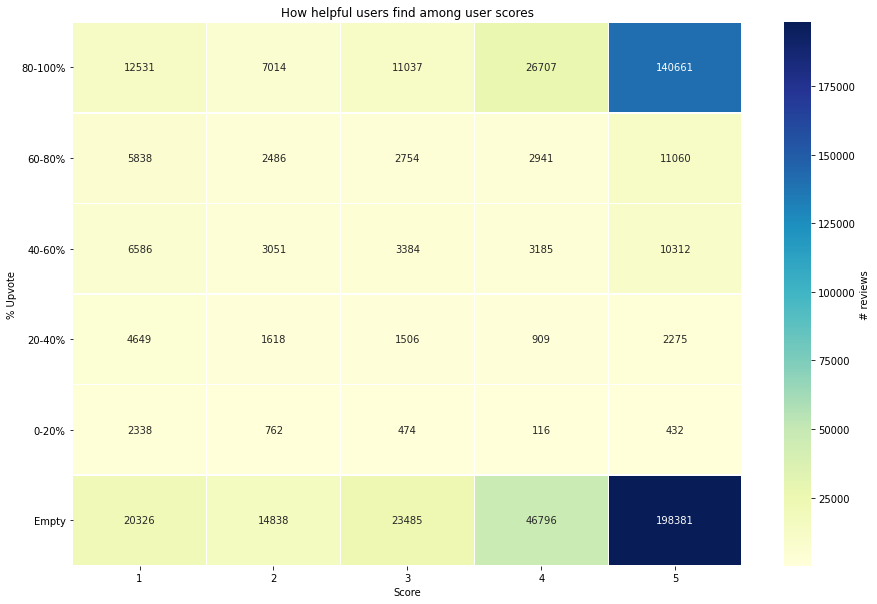

In [13]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

In [14]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

In [15]:
train_df = pd.concat([X, y], axis=1)

In [25]:
train_df

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
...,...,...
568449,Great for sesame chicken..this is a good if no...,1
568450,I'm disappointed with the flavor. The chocolat...,0
568451,"These stars are small, so you can give 10-15 o...",1
568452,These are the BEST treats for training and rew...,1


In [24]:
train_df.to_csv('reviews.csv')

In [30]:
class Sequences(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(df.Text.tolist())
        self.labels = df.Score.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
DATA_PATH = 'reviews.csv'

In [33]:
dataset = Sequences(DATA_PATH)
train_loader = DataLoader(dataset, batch_size=4096)

print(dataset[5][0].shape)

(1, 1072)


In [34]:
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [35]:
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=1072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [37]:
model.train()
train_losses = []
for epoch in range(10):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch #1	Train Loss: 0.338


Epoch #2	Train Loss: 0.213


Epoch #3	Train Loss: 0.192


Epoch #4	Train Loss: 0.168


Epoch #5	Train Loss: 0.144


Epoch #6	Train Loss: 0.124


Epoch #7	Train Loss: 0.108


Epoch #8	Train Loss: 0.094


Epoch #9	Train Loss: 0.084


Epoch #10	Train Loss: 0.079


In [38]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())

        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [40]:
test_text = """We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented. The waiters were attentive and service overall was good. The restaurant looked to have been recently decorated. Overall a good meal and great value we will certainly be going back."""
predict_sentiment(test_text)

1.0: Positive sentiment
